# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

# Data Information

In [3]:
DIR = '/content/drive/MyDrive/DATASET/Images /Cheetah & Lions/images'

img_height, img_width = 224, 224
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root = DIR, transform = transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = Subset(dataset, range(train_size))
validation_dataset = Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

print('Total_dataset',len(dataset),'Train_dataset',len(train_dataset),'Validation_Dataset',len(validation_dataset))

Total_dataset 201 Train_dataset 160 Validation_Dataset 41


## Display Image

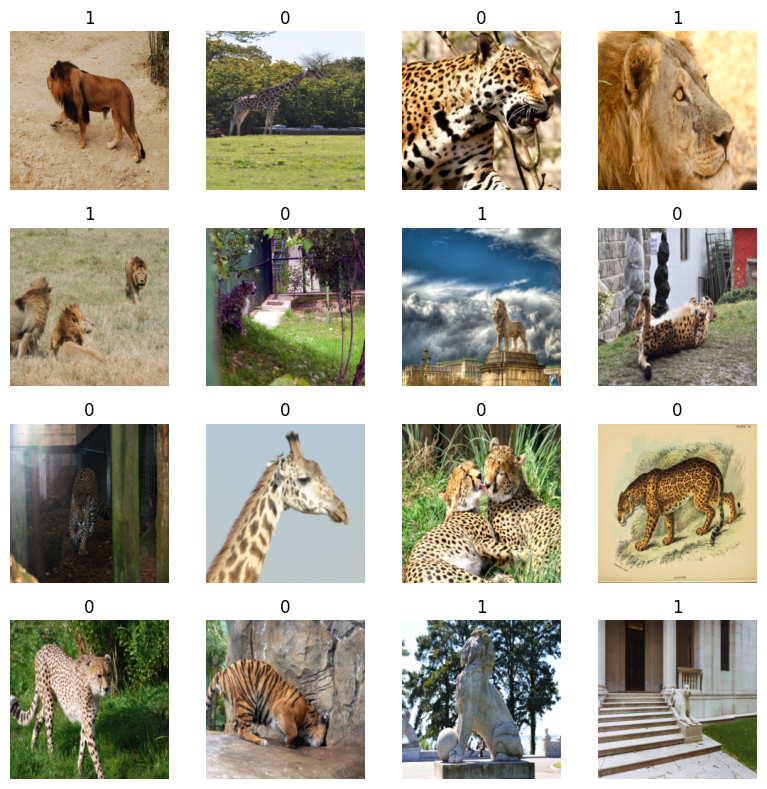

In [4]:
images, labels = next(iter(train_loader))

num_images = len(images)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
  if i < num_images:
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(labels[i].item())
    ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
num_classes = len(dataset.classes)
print("Number of Classes:", num_classes)

Number of Classes: 2


In [6]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [7]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = torch.flatten(x, 1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=num_classes).to(device)

In [8]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [9]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
epochs = 10

print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Learning Rate")
print("-" * 57)

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_correct += (val_outputs.argmax(1) == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    lr = optimizer.param_groups[0]['lr']
    print(f"{epoch+1:5d} | {train_losses[-1]:.4f}     | {train_accuracies[-1]:.4f}   | {val_losses[-1]:.4f}   | {val_accuracies[-1]:.4f}  | {lr:.6f}")

print("-" * 57)
print("Training complete.")

Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Learning Rate
---------------------------------------------------------
    1 | 0.7121     | 0.6062   | 1.3084   | 0.0000  | 0.001000
    2 | 0.6647     | 0.6312   | 0.9023   | 0.0000  | 0.001000
    3 | 0.6446     | 0.6312   | 1.1119   | 0.0000  | 0.001000
    4 | 0.6121     | 0.6500   | 1.0808   | 0.0244  | 0.001000
    5 | 0.5891     | 0.6750   | 1.4358   | 0.0732  | 0.001000
    6 | 0.5786     | 0.6750   | 0.8168   | 0.4390  | 0.001000
    7 | 0.5289     | 0.7250   | 0.7110   | 0.5366  | 0.001000
    8 | 0.5111     | 0.7688   | 1.1582   | 0.2927  | 0.001000
    9 | 0.4475     | 0.8375   | 1.3374   | 0.1951  | 0.001000
   10 | 0.3838     | 0.8562   | 0.8390   | 0.5122  | 0.001000
---------------------------------------------------------
Training complete.


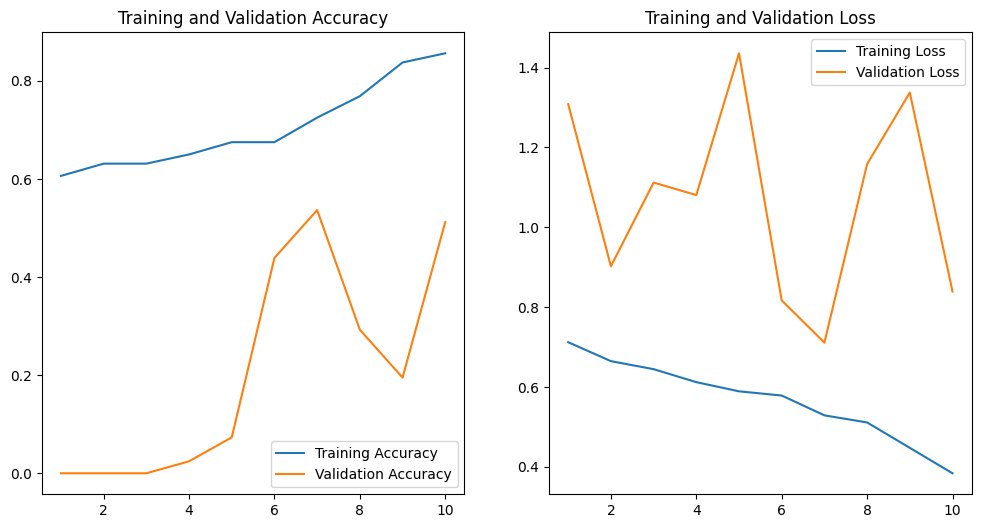

In [10]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()